In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import difflib
import re
import torch
import textwrap
from datasets import load_dataset, Dataset

In [3]:
file = 'Books_gale.csv'
folder = './Data'
dataset = load_dataset("csv", data_files=folder + '/' + file, nrows=100)
model_name = 'roBERTa'

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Author', 'Title', 'Publication', 'Date', 'Place', 'Full_text', 'URL'],
        num_rows: 100
    })
})

In [5]:
len(dataset['train']['Full_text'])  # Display the first record to understand its structure

with open("books_text.txt", "a") as f:
    for text in dataset['train']['Full_text']:
        f.write("\n\n--- START OF TEXT PIECE ---\n\n")
        f.write(text)
        f.write("\n\n--- END OF TEXT PIECE ---\n\n")

In [6]:
# --- 1. Define the Helper Functions for text cleaning ---
def pre_clean_for_model(text: str) -> str:
    """
    Performs a hard scrub of the text to remove only the most severe OCR noise
    before sending it to a language model.
    """
    if not isinstance(text, str):
        return ""
    text = text.replace('\n', ' ').replace('<NEWPAGE>', ' ')
    text = re.sub(r'[^A-Za-z0-9\s.,!?-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [7]:
# --- 2. The Final, Robust, Chunk-Based Correction Function FOR A SINGLE REVIEW ---
def correct_review_with_mlm(review_text: str, nlp_pipeline, spell_checker, chunk_size, overlap, max_len=510):
    """
    (FINAL ROBUST & RECOVERABLE VERSION)
    Corrects a single review. Returns the corrected text on success, or None on failure.
    """
    if not review_text or not review_text.strip():
        return ""

    words = review_text.split()
    all_corrected_chunks = []
    start = 0
    has_failed = False  # Flag to track if any chunk fails

    while start < len(words):
        end = start + chunk_size
        chunk_text = " ".join(words[start:end])

        try:
            tokens = re.findall(r'\w+|[^\w\s]', chunk_text)
            unknown_words = spell_checker.unknown([token for token in tokens if token.isalpha()])
            
            if not unknown_words:
                all_corrected_chunks.append(chunk_text)
            else:
                masked_sentences, correction_map = [], {}
                for i, token in enumerate(tokens):
                    if token in unknown_words:
                        temp_tokens = list(tokens)
                        temp_tokens[i] = nlp_pipeline.tokenizer.mask_token
                        masked_text = nlp_pipeline.tokenizer.convert_tokens_to_string(temp_tokens)
                        
                        # --- DEFINITIVE SAFETY CHECK ---
                        token_ids = nlp_pipeline.tokenizer(masked_text, truncation=False)['input_ids']
                        if len(token_ids) > max_len:
                            print(f"WARNING: A masked sentence in a chunk was too long ({len(token_ids)} tokens). Skipping this specific correction.")
                            has_failed = True
                            continue
                        
                        masked_sentences.append(masked_text)
                        correction_map[len(masked_sentences) - 1] = i
                
                if masked_sentences:
                    # The call for 'fill-mask' does NOT take 'truncation'.
                    predictions = nlp_pipeline(masked_sentences)
                    
                    if isinstance(predictions[0], dict):
                        predictions = [predictions]
                    
                    corrected_tokens = list(tokens)
                    for i, pred_group in enumerate(predictions):
                        token_idx_to_correct = correction_map[i]
                        best_suggestion = None
                        for pred in pred_group:
                            suggestion = pred['token_str'].strip()
                            if suggestion.isalpha() and len(suggestion) > 1:
                                best_suggestion = suggestion
                                break
                        if best_suggestion:
                            corrected_tokens[token_idx_to_correct] = best_suggestion
                    
                    # Reassemble tokens with spaces correctly
                    reassembled_text = " ".join(corrected_tokens)
                    reassembled_text = re.sub(r'\s([.,!?-])', r'\1', reassembled_text)
                    all_corrected_chunks.append(reassembled_text)
                else:
                     all_corrected_chunks.append(chunk_text)

        except Exception as e:
            print(f"WARNING: An error occurred on a chunk. Marking review as failed. Error: {e}")
            all_corrected_chunks.append(chunk_text) # Append original chunk on error
            has_failed = True # Set the failure flag
        finally:
            start += chunk_size - overlap
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # --- Propagate Failure Signal ---
    if has_failed:
        print("FAILED RETURNING NONE")
        return None 

    # --- Reassembly Logic ---
    final_text_words = []
    for i, chunk_text in enumerate(all_corrected_chunks):
        chunk_words = chunk_text.split()
        if i == 0:
            final_text_words.extend(chunk_words)
        else:
            final_text_words.extend(chunk_words[overlap:])
    
    return " ".join(final_text_words)

# --- 3. The Main Mapping Function for .map() ---
def apply_cleaning_in_batch(examples, nlp_pipeline, spell_checker, chunk_size=400, overlap=50):
    """Applies the robust, chunk-based correction to a batch of reviews."""
    pre_cleaned_texts = [pre_clean_for_model(text) for text in examples['Full_text']]
    
    final_cleaned_texts = []
    for text in pre_cleaned_texts:
        corrected_text = correct_review_with_mlm(text, nlp_pipeline, spell_checker, chunk_size, overlap)
        if corrected_text is None:
            # If the inner function signalled a failure, mark it for recovery.
            final_cleaned_texts.append("__FAILED__")
        else:
            final_cleaned_texts.append(corrected_text)
            
    return {'Cleaned_text': final_cleaned_texts}


In [8]:
# --- 4. Load Models and Run ---

print("Loading the text correction model (this may take a moment)...")
corrector = pipeline(
    "fill-mask",
    model="roberta-base",
    device_map="auto"
)
spell = SpellChecker()
print("Model loaded successfully.")


# --- 5. Run the Main Pipeline ---
print("\n--- Applying the FINAL cleaning pipeline ---")
dataset = dataset.map(
    apply_cleaning_in_batch,
    batched=True,
    batch_size=1, # Process 8 full reviews at a time
    fn_kwargs={'nlp_pipeline': corrector, 'spell_checker': spell, 'chunk_size' : 400, 'overlap':50}
)
print("Processing complete.")



Loading the text correction model (this may take a moment)...


Device set to use cuda:0


Model loaded successfully.

--- Applying the FINAL cleaning pipeline ---


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors


FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RETURNING NONE
FAILED RET

In [9]:

# --- 5. Save the Intermediate Results ---
print("\n--- Saving intermediate results (with any failures) ---")
dataset['train'].to_csv(f"cleaned_{model_name}_reviews_with_failures.csv", index=False)
print("File saved.")




--- Saving intermediate results (with any failures) ---


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

File saved.


In [10]:

# --- 6. THE RECOVERY PROCESS ---

print("\n--- Starting Recovery Process ---")
# Load the dataset that contains the '__FAILED__' markers
recovery_dataset = load_dataset("csv", data_files="cleaned_roBERTa_reviews_with_failures.csv")

# Filter to get only the rows that failed
failed_examples = recovery_dataset['train'].filter(
    lambda example: example['Cleaned_text'] == "__FAILED__"
)

if len(failed_examples) > 0:
    print(f"Found {len(failed_examples)} failed examples to re-process.")

    # Re-run the pipeline on the small, failed dataset.
    # Use a smaller batch_size or chunk_size for more safety.
    reprocessed_failures = failed_examples.map(
        apply_cleaning_in_batch,
        batched=True,
        batch_size=1, # Process 8 full reviews at a time
        fn_kwargs={'nlp_pipeline': corrector, 'spell_checker': spell, 'chunk_size' : 200, 'overlap':30}
    )

    print("Re-processing complete. Now merging results.")
    # You would now merge these corrected results back into your main file.
    # The easiest way is often with Pandas.
    main_df = pd.read_csv("cleaned_roBERTa_reviews_with_failures.csv")
    reprocessed_df = reprocessed_failures.to_pandas()

    # Create a dictionary from the reprocessed data for easy mapping
    # We need a unique identifier; let's assume 'Full_text' is unique enough for this.
    update_map = pd.Series(reprocessed_df['Cleaned_text'].values, index=reprocessed_df['Full_text']).to_dict()

    # Update the main DataFrame
    main_df['Cleaned_text'] = main_df.apply(
        lambda row: update_map.get(row['Full_text'], row['Cleaned_text']),
        axis=1
    )

    main_df.to_csv("cleaned_roBERTa_reviews_final.csv", index=False)
    print("Final, fully cleaned file saved as 'cleaned_reviews_final.csv'")

else:
    print("No failed examples found. Your initial run was successful!")



--- Starting Recovery Process ---


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Found 62 failed examples to re-process.


Map:   0%|          | 0/62 [00:00<?, ? examples/s]

Re-processing complete. Now merging results.
Final, fully cleaned file saved as 'cleaned_reviews_final.csv'


In [11]:
# --- 1. Load the dataset with cleaned text into a dataframe ---
dataset = load_dataset("csv", data_files="cleaned_roBERTa_reviews_final.csv")

# --- 2. Define the SequenceMatcher comparison function ---
def calculate_similarity(text_a: str, text_b: str) -> float:
    """
    Calculates a similarity ratio between two strings using SequenceMatcher.
    Returns a float between 0.0 (totally different) and 1.0 (identical).
    """
    # Ensure inputs are strings to avoid errors
    if not isinstance(text_a, str) or not isinstance(text_b, str):
        return 0.0
    
    # Calculate and return the similarity ratio
    return difflib.SequenceMatcher(None, text_a, text_b).ratio()

# --- 3. Define the Mapping Function for Batch Processing ---
def add_similarity_in_batch(examples):
    """
    This function is designed for .map(batched=True).
    'examples' is a dictionary where each value is a LIST of items.
    """
    # Use a list comprehension with zip to efficiently process the batch.
    # This pairs up each 'Full_text' with its corresponding 'Cleaned_text'.
    similarity_scores = [
        calculate_similarity(pre_clean_for_model(original), cleaned)
        for original, cleaned in zip(examples['Full_text'], examples['Cleaned_text'])
    ]
    
    # Return a dictionary with the new column. The value must be a list.
    return {'similarity_score': similarity_scores}


# --- 4. Apply the Mapping ---
print("--- Applying the similarity calculation using batching ---")

dataset = dataset.map(
    add_similarity_in_batch,
    batched=True,
    batch_size=500  # For CPU tasks, a larger batch size is fine
)

print("\n--- Dataset after adding the 'similarity_score' column ---")
print(dataset['train'].to_pandas())


Generating train split: 0 examples [00:00, ? examples/s]

--- Applying the similarity calculation using batching ---


Map:   0%|          | 0/100 [00:00<?, ? examples/s]


--- Dataset after adding the 'similarity_score' column ---
               Author                                              Title  \
0        Marlowe, Sam  A satisfying treat of plain and simple storyte...   
1                Null                                Seeing is believing   
2       Craig, Amanda                   A spooky power to charm all ages   
3        Mount, Harry              A lavatory read from the 16th century   
4   Koning, Christina                                            Fiction   
..                ...                                                ...   
95               Null                                        Bestsellers   
96               Null                                        Bestsellers   
97               Null                                        Bestsellers   
98       Davis, Clive                Who Wants to Be a Jazz Millionaire?   
99   Jones, Nicolette            Fantasy Matches how our Brains are Made   

   Publication         Date

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  2.,
         0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  6.,
         1.,  7.,  3.,  4.,  6.,  2.,  1.,  9.,  9., 19., 17.]),
 array([0.45006542, 0.46106411, 0.4720628 , 0.48306149, 0.49406018,
        0.50505887, 0.51605757, 0.52705626, 0.53805495, 0.54905364,
        0.56005233, 0.57105102, 0.58204972, 0.59304841, 0.6040471 ,
        0.61504579, 0.62604448, 0.63704317, 0.64804187, 0.65904056,
        0.67003925, 0.68103794, 0.69203663, 0.70303532, 0.71403402,
        0.72503271, 0.7360314 , 0.74703009, 0.75802878, 0.76902747,
        0.78002617, 0.79102486, 0.80202355, 0.81302224, 0.82402093,
        0.83501962, 0.84601832, 0.85701701, 0.8680157 , 0.87901439,
        0.89001308, 0.90101177, 0.91201047, 0.92300916, 0.93400785,
        0.94500654, 0.95600523, 0.96700392, 0.97800262, 0.98900131,
        1.        ]),
 <BarContainer

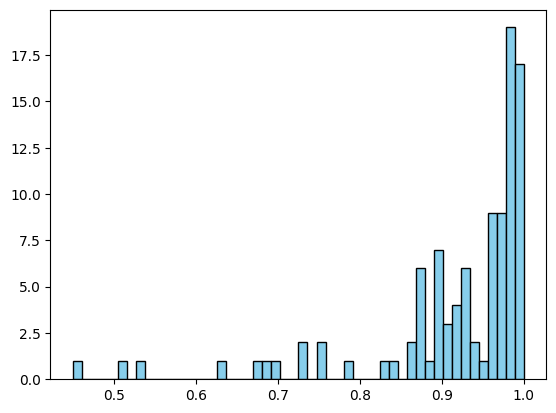

In [12]:
plt.hist(dataset['train']['similarity_score'], bins=50, color='skyblue', edgecolor='black')

In [13]:
df_sorted = dataset['train'].to_pandas().sort_values(by='similarity_score')
# Filter for the most heavily altered reviews
#suspicious_reviews = df_sorted[df_sorted['similarity_score'].between(0.55, 0.58, inclusive='neither')]
suspicious_reviews = df_sorted[df_sorted['similarity_score'] <1]

print(f"Found {len(suspicious_reviews)} reviews with a similarity score below 0.05 to inspect.")

Found 95 reviews with a similarity score below 0.05 to inspect.


In [14]:
# --- The Side-by-Side Pretty Print Function ---
def pretty_print_side_by_side(review_series, total_width=120):
    """
    Prints a side-by-side comparison of the pre-cleaned original text and
    the final roBERTa-restored text for a single review.

    Args:
        review_series (pd.Series): A single row from your DataFrame.
        total_width (int): The total width of the output in characters.
    """
    # Calculate the width for each text column
    divider = "   |   "
    col_width = (total_width - len(divider)) // 2

    # Get the two versions of the text
    original_pre_cleaned = pre_clean_for_model(review_series['Full_text'])
    roBERTa_cleaned = review_series['Cleaned_text']
    
    # Wrap the text in each column into lists of lines
    original_lines = textwrap.wrap(original_pre_cleaned, width=col_width)
    cleaned_lines = textwrap.wrap(roBERTa_cleaned, width=col_width)
    
    # --- Start Printing ---
    print("=" * total_width)
    # Use .get() to avoid an error if 'similarity_score' doesn't exist
    score = review_series.get('similarity_score', 'N/A')
    if isinstance(score, float):
        score = f"{score:.4f}"
    print(f"Similarity Score: {score}".center(total_width))
    print("-" * total_width)
    
    # Print headers
    header_original = "Pre-Cleaned Original".center(col_width)
    header_cleaned = "roBERTa Restored Text".center(col_width)
    print(f"{header_original}{divider}{header_cleaned}")
    print("-" * total_width)

    # Print the lines side-by-side
    max_lines = max(len(original_lines), len(cleaned_lines))
    for i in range(max_lines):
        # Get the line for each side, or an empty string if one side is shorter
        left_line = original_lines[i] if i < len(original_lines) else ""
        right_line = cleaned_lines[i] if i < len(cleaned_lines) else ""
        
        # Print the formatted line with padding
        print(f"{left_line:<{col_width}}{divider}{right_line:<{col_width}}")
        
    print("=" * total_width + "\n")

In [16]:
pretty_print_side_by_side(suspicious_reviews.iloc[1])

                                                Similarity Score: 0.5118                                                
------------------------------------------------------------------------------------------------------------------------
                  Pre-Cleaned Original                     |                    roBERTa Restored Text                  
------------------------------------------------------------------------------------------------------------------------
gM wtflr BJBgBa liBlmBig Jn fiRHBBH iQ Wb mB hBI wBbmB     |   gM wtflr BJBgBa liBlmBig Jn fiRHBBH iQ Wb mB hBI wBbmB  
BHbR An SO IS IT ALL HYPE? There have been so many bogus   |   BHbR An SO IS IT ALL HYPE? There have been so many bogus
sto - r ies about big-money advanc - es to unknown         |   market- r uled about big- money and- es to unknown      
artists that these deals should perhaps be measured in a   |   artists that these deals should perhaps be measured in a
new unit of cur - rency . The Magnus 